# [SF_DST-27] Project 7. Car Price prediction II

<img src= "https://mar.prod.image.rndtech.de/var/storage/images/haz/nachrichten/wirtschaft/niedersachsen/diese-vw-plattform-soll-autoscout24-und-mobile.de-angreifen/640945376-1-ger-DE/Diese-VW-Plattform-soll-Autoscout24-angreifen_master_reference.jpg">

In [1]:
!nvidia-smi

Fri Nov 19 20:22:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:0B:00.0  On |                  N/A |
| 20%   36C    P8     5W / 120W |    445MiB /  6070MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#!pip install -q tensorflow==2.3

In [3]:
#аугментации изображений
#!pip install -q albumentations==0.5.1


In [4]:

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)
from sklearn import metrics\

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import albumentations

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [6]:
!pip freeze > requirements.txt

In [7]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.8.10 (default, Sep 28 2021, 16:10:42) 
Numpy        : 1.19.5
Tensorflow   : 2.6.0


## Functions definition

In [8]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [9]:
def metrics_func(y_true, y_pred):
    ''' Function prints list of based metric'''
    #Mean Absolute Error
    mae = metrics.mean_absolute_error(y_true, y_pred)
    #Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    #Symmetric Mean Absolute Percentage Error
    smape = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

    #Mean Squared Error
    mse = metrics.mean_squared_error(y_true, y_pred)

    #Root Mean Squared Error
    rmse = np.sqrt(mse)

    #Coefficient of determination
    R_2 = metrics.r2_score(y_true, y_pred)


    print(f'MAE Mean Absolute Error {mae:0.2f}')
    print(f'MAPE  Mean Absolute Percentage Error {mape:0.2f}%')
    print(f'SMAPE Symmetric Mean Absolute Percentage Error {smape:0.2f}%')
    print(f'MSE Mean Squared Error {mse:0.2f}')
    print(f'RMSE Root Mean Squared Error {rmse:0.2f}')
    print(f'R_2 Coefficient of determination {R_2:0.2f}')
    return


In [10]:
def check_df_before_merg(d_df1,d_df2):
    ''' the function to compare of data types both datasets
    was copied from SF colleagues'''

    list_of_names1 = list(d_df1.columns)
    temp_dict = {}
    temp_dict['feature_train'] = list_of_names1
    temp_dict['type_train'] = d_df1.dtypes
    temp_dict['sample_train'] = d_df1.loc[5].values
    temp_df1 = pd.DataFrame.from_dict(temp_dict)


    list_of_names2 = list(d_df2.columns)
    temp_dict2 = {}
    temp_dict2['feature_test'] = list_of_names2
    temp_dict2['type_test'] = d_df2.dtypes
    temp_dict2['sample_test'] = d_df2.loc[5].values
    temp_df2 = pd.DataFrame.from_dict(temp_dict2)

    temp_insert = pd.DataFrame(columns=['< - >'])

    temp_df = pd.concat([temp_df1,temp_insert, temp_df2], axis=1, sort=False)
    temp_df.reset_index(inplace = True)
    del temp_df['index']
    temp_df['< - >'] = '| - |'
    display(temp_df)

    temp_dict3 = {}
    temp_df3= pd.DataFrame(temp_df)
    temp_list  = []
    temp_list2  = []
    temp_list3  = []
    temp_list4  = []


    for i in range(len(temp_df)):
        if str(temp_df3['type_train'][i]) != str(temp_df3['type_test'][i]):
            temp_list.append(temp_df3['feature_train'][i])
            temp_list2.append(temp_df3['feature_test'][i])
            temp_list3.append(str(temp_df3['type_train'][i]) + ' != ' + str(temp_df3['type_test'][i]))
            temp_list4.append(i)

    temp_dict3['index']= temp_list4
    temp_dict3['feature_train']= temp_list
    temp_dict3['divergences'] = temp_list3
    temp_dict3['feature_test']= temp_list2

    temp_df4 = pd.DataFrame.from_dict(temp_dict3)
    temp_df4.set_index('index',inplace=True)

    print(f'The data types are different in {len(temp_df4)} columns\n')
    display(temp_df4)

In [11]:

def clean_smb(smb):
    ''' the function does remove the symbols
    in the string data'''

    smb = smb.replace("}",'')
    smb = smb.replace("{",'')
    smb = smb.replace("]",'')
    smb = smb.replace("]",'')
    smb = smb.replace('"','')
    smb = smb.strip('[]')
    smb = smb.split(',')
    return smb

In [12]:
def float_value(feature):
    ''' The function cleans the digits from other
    symbols and brings them to float'''

    pattern = re.compile('([^\d.]+)')
    feature = feature.replace(pattern, '')
    oft_value = feature.value_counts(sort=True).keys()[0]
    feature = feature.replace('', oft_value).astype(float, errors = 'raise')
    return feature

In [13]:
def cat_feature_overview(feature):
    ''' The function outputs the feature's info'''

    print(f'Total lines: {len(feature)}')
    print(f'Data types: {feature.dtypes}')
    print(f'Total values: {feature.count()}')
    print(f'The most frequent value: {feature.value_counts(sort=True).keys()[0]}')
    print(f'The less frequent value: {feature.value_counts(sort=True).keys()[-1]}')
    print(f'Unique values: {feature.nunique()}')
    print(f'Missing values: {feature.isna().sum()}')
    sns.countplot(y = feature, order = feature.value_counts(sort=True).index)

    return


In [14]:
def num_feature_overview(feature):
    ''' The function outputs the feature's info'''

    print(f'Total lines: {len(feature)}')
    print(f'Data types: {feature.dtypes}')
    print(f'Total values: {feature.count()}')
    print(f'The most frequent value: {feature.value_counts(sort=True).keys()[0]}')
    print(f'The less frequent value: {feature.value_counts(sort=True).keys()[-1]}')
    print(f'Unique values: {feature.nunique()}')
    print(f'Missing values: {feature.isna().sum()}')

    return

In [15]:
def subset_by_iqr(feature, whisker_width=1.5):
    '''Remove outliers from a dataframe by column, including optional
       whiskers, removing rows for which the column value are
       less than Q1-1.5IQR or greater than Q3+1.5IQR.
    '''
    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    iqr = q3 - q1
    low_outlier = q1 - whisker_width*iqr
    high_outlier = q3 + whisker_width*iqr
    column_median = feature.median()

    # Apply filter with respect to IQR, including optional whiskers
    # else mode()

    return feature.apply(lambda x: x if (x > low_outlier and x < high_outlier) else column_median)

In [16]:
def check_iqr(feature, whisker_width=1.5):
    '''defines the quantiles at the column, including optional
       whiskers with Q1-1.5IQR and Q3+1.5IQR boarders.
    '''
    global IQRs
    global q1
    global q3

    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    iqr = q3 - q1
    low_outlier = q1 - whisker_width*iqr
    high_outlier = q3 + whisker_width*iqr
    IQRs = pd.DataFrame({'Q1' : [q1], 'Q3' : [q3], 'IQR' : [iqr], 'low_outlier' : [low_outlier], 'high_outlier' : [high_outlier]})

    sns.set_style("darkgrid")


    # feature's distribution
    x = feature
    plt.figure(figsize=(10,5))
    sns.distplot(x, kde=True)
    plt.axvline(low_outlier, color='red')
    plt.axvline(high_outlier, color='red')
    plt.axvline(q1, color='blue',linestyle='--')
    plt.axvline(q3, color='blue',linestyle='--')
    plt.show()


    return IQRs, q1, q3

# 1. DATA



In [17]:
    #DATA_DIR = '../input/sf-dst-car-price-prediction-part2-v2
    #train = pd.read_csv(DATA_DIR + 'train.csv')
    #test = pd.read_csv(DATA_DIR + 'test.csv')
    #sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

    train = pd.read_csv('././data/train.csv')
    test = pd.read_csv('././data/test.csv')
    sample_submission = pd.read_csv('././data/sample_submission.csv')

    print(f'train.shape {train.shape}, test.shape{test.shape}, sample_submission.shape {sample_submission.shape}')


train.shape (6682, 22), test.shape(1671, 21), sample_submission.shape (1671, 2)


In [18]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [19]:
train.nunique()


bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

### Feauters types
Features| Type
----|---
bodyType | категориальный
brand |  категориальный
color |  категориальный
description |  текстовый
engineDisplacement | числовой, представленный как текст
enginePower | числовой, представленный как текст
fuelType | категориальный
mileage |  числовой
modelDate | числовой
model_info | категориальный
name | категориальный, желательно сократить размерность
numberOfDoors | категориальный
price | числовой, целевой
productionDate | числовой
sell_id | изображение (файл доступен по адресу, основанному на sell_id)
vehicleConfiguration | не используется (комбинация других столбцов)
vehicleTransmission | категориальный
Владельцы | категориальный
Владение | числовой, представленный как текст
ПТС | категориальный
Привод | категориальный
Руль | категориальный



#### Compare the datasets train and test


In [20]:
check_df_before_merg(train, test)


,feature_train,type_train,sample_train,< - >,feature_test,type_test,sample_test
0,bodyType,object,седан,| - |,bodyType,object,седан
1,brand,object,MERCEDES,| - |,brand,object,BMW
2,color,object,чёрный,| - |,color,object,синий
3,description,object,Автомобиль в очень хорошем состоянии. Бережная...,| - |,description,object,"Добрый день, продаю свой автомобиль. Перекупам..."
4,engineDisplacement,object,1.8 LTR,| - |,engineDisplacement,object,3.0 LTR
5,enginePower,object,184 N12,| - |,enginePower,object,340 N12
6,fuelType,object,бензин,| - |,fuelType,object,бензин
7,mileage,int64,229000,| - |,mileage,int64,72000
8,modelDate,int64,2006,| - |,modelDate,int64,2016
9,model_info,object,C_KLASSE,| - |,model_info,object,5ER


The data types are different in 1 columns



,feature_train,divergences,feature_test
index,,,
12,price,float64 != nan,NaN


## 1.1 Naive model

In [21]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)

In [22]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info== '{row[0]}' and productionDate == {row[1]}"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
metrics_func(data_test['price'], predicts.values[:, 0])

MAE Mean Absolute Error 369928.60
MAPE  Mean Absolute Percentage Error 20.45%
SMAPE Symmetric Mean Absolute Percentage Error 18.61%
MSE Mean Squared Error 814685382860.38
RMSE Root Mean Squared Error 902599.24
R_2 Coefficient of determination 0.76


## 1.2  Exploration Data Analysis (EDA)


In [23]:
#Column sample idificates the train and  the test samplea\n",
test['sample'] = 0
train['sample'] = 1

#Column price is the target. Empty cells of test sample is filled up with 0\n",
test['price'] = 0


In [24]:
#Merging the train and test samples
df = test.append(train, sort=False).reset_index(drop=True)
print(f'the shape of the merged dataset is {df.shape}')

the shape of the merged dataset is (8353, 23)


In [25]:
#import pandas_profiling
#profile = pandas_profiling.ProfileReport(df)
#profile.to_file("output.html")
#profile

### Profiling summary

    Using quantitative techniques and visual methods of representation, EDA looks to tell a story about the existing data based on a broad examination of patterns, trends, outliers, and unexpected results.\n",
    * _30 not treated features in the dataset:
        * _CAT 18
        * _NUM 5
    * Missing cells 2.8%
    * Duplicate rows 0.0%
    * 'sell id' doesn't contain any useful information.
    * 'vehicleConfiguration' duplicates the information are provided by other features.
    * 'description' contains useful information that can be treated
    * 'equipment_dict' and 'complectation_dict' have a similar data and can be merged.
    * the numerical features aren't normaly distributed. They have to be normalized.
    * the categorical datas in the features: bodyType, fuelType, numberOfDoors, vehicleTransmission, ПТС, Руль are disbalanced
    * the features are highly correlated with each other:
        *  modelDate, productionDate, mileage, Владельцы, price

### 1.3 Features preprocessing
### Bodytype

In [26]:
df['bodyType'] = df['bodyType'].astype(str).apply(lambda x: None if x.strip() == '' else x)
df['bodyType'] = df.bodyType.apply(lambda x: x.split(' ')[0].lower())

In [27]:
df.bodyType[1:5]

1     купе
2     купе
3    седан
4    седан
Name: bodyType, dtype: object

Total lines: 8353
Data types: object
Total values: 8353
The most frequent value: седан
The less frequent value: пикап
Unique values: 13
Missing values: 0


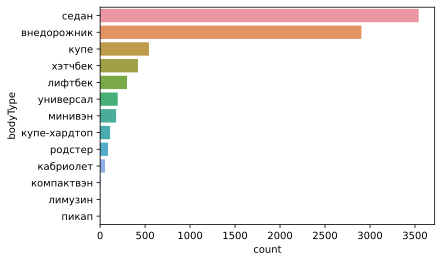

In [28]:
cat_feature_overview(df.bodyType)

### brand

Total lines: 8353
Data types: object
Total values: 8353
The most frequent value: BMW
The less frequent value: AUDI
Unique values: 3
Missing values: 0


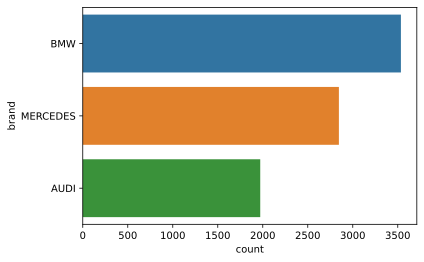

In [29]:
cat_feature_overview(df.brand)

### color

Total lines: 8353
Data types: object
Total values: 8353
The most frequent value: чёрный
The less frequent value: розовый
Unique values: 16
Missing values: 0


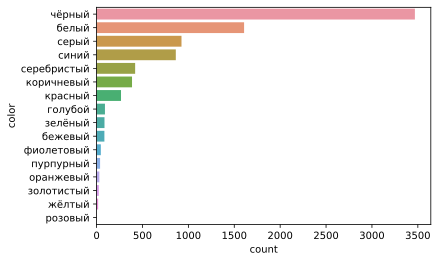

In [30]:
cat_feature_overview(df.color)

### fuelType

Total lines: 8353
Data types: object
Total values: 8353
The most frequent value: бензин
The less frequent value: электро
Unique values: 4
Missing values: 0


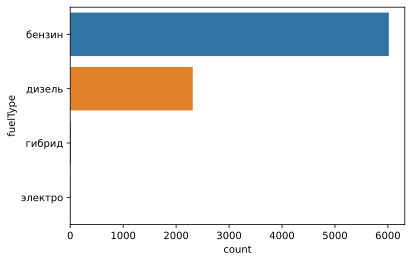

In [31]:
cat_feature_overview(df.fuelType)

### Владельцы

Total lines: 8353
Data types: object
Total values: 8352
The most frequent value: 3 или более
The less frequent value: 2 владельца
Unique values: 3
Missing values: 1


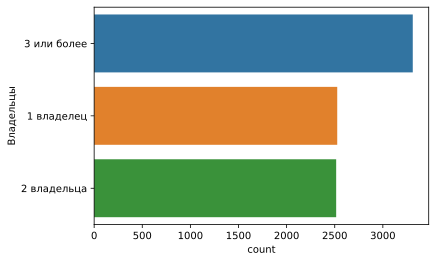

In [32]:
cat_feature_overview(df.Владельцы)

### model_info

Total lines: 8353
Data types: object
Total values: 8353
The most frequent value: 5ER
The less frequent value: W201
Unique values: 122
Missing values: 0


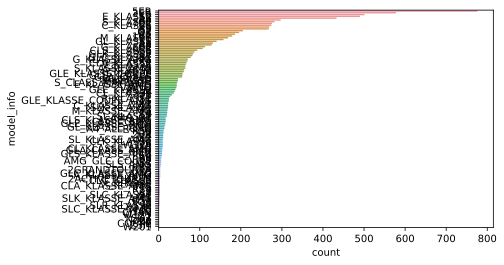

In [33]:
cat_feature_overview(df.model_info)

In [34]:
df.model_info.value_counts()

5ER         776
3ER         578
X5          501
E_KLASSE    490
A6          433
           ... 
None          1
Z8            1
COUPE         1
Z3M           1
W201          1
Name: model_info, Length: 122, dtype: int64

### Привод

Total lines: 8353
Data types: object
Total values: 8353
The most frequent value: полный
The less frequent value: передний
Unique values: 3
Missing values: 0


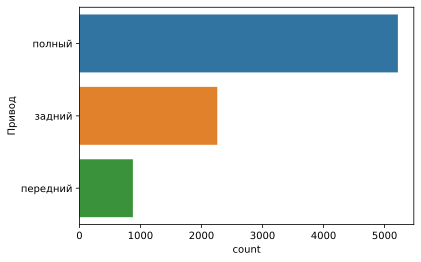

In [35]:
cat_feature_overview(df.Привод)

### mileage

In [36]:
num_feature_overview(df.mileage)

Total lines: 8353
Data types: int64
Total values: 8353
The most frequent value: 120000
The less frequent value: 21291
Unique values: 3507
Missing values: 0


/home/as/venv/tfgpu/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


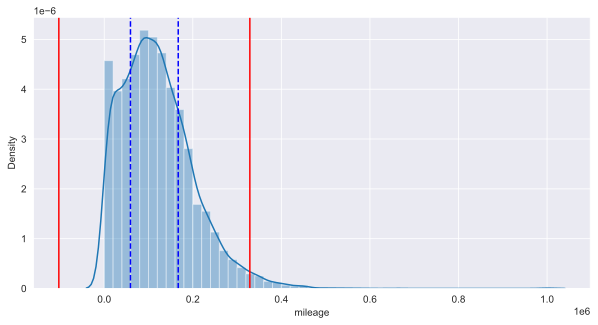

(        Q1        Q3       IQR  low_outlier  high_outlier
 0  59246.0  167084.0  107838.0    -102511.0      328841.0,
 59246.0,
 167084.0)

In [37]:
check_iqr(df.mileage)

### productionDate

In [38]:
num_feature_overview(df.productionDate)

Total lines: 8353
Data types: int64
Total values: 8353
The most frequent value: 2013
The less frequent value: 1989
Unique values: 39
Missing values: 0


/home/as/venv/tfgpu/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


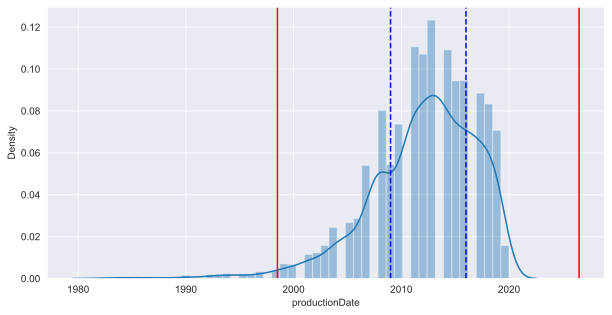

(       Q1      Q3  IQR  low_outlier  high_outlier
 0  2009.0  2016.0  7.0       1998.5        2026.5,
 2009.0,
 2016.0)

In [39]:
check_iqr(df.productionDate)

### Владение


In [40]:
df.Владение[:10]


0     6 лет и 3 месяца
1    6 лет и 6 месяцев
2                  NaN
3                  NaN
4                  NaN
5               3 года
6                  NaN
7    2 года и 2 месяца
8    2 года и 4 месяца
9                  NaN
Name: Владение, dtype: object

Convertation the string data "Duration" to numerical

In [41]:
lst = []

lst_years = ['год','года', 'лет']
lst_month = ['месяца', 'месяцев', 'месяц']

for index, row in df.iterrows():
    dur = 0
    try:
        a,b = row['Владение'].split(' ')[0], row['Владение'].split(' ')[1]
        c,d = row['Владение'].split(' ')[-2], row['Владение'].split(' ')[-1]
        if b in lst_years:
            dur += int(a)
        if d in lst_month:
            dur += int(c)/12
        lst.append(dur)
    except:

        lst.append(None)


df['Владение'] = pd.DataFrame(lst)

In [42]:
df['Владение'][:10]


df1 = df.copy()
df1.Владение.fillna(0, inplace=True)

In [43]:
df1['Владение'].isna().sum()

0

In [44]:
q1_holding = []
q2_holding = []
q3_holding = []

for index, row in df1.iterrows():
    q1_query = f'mileage < {q1} and productionDate == {row.productionDate}'
    q1_holding.append(df1.query(q1_query)['Владение'].mean())

    q2_query = f'mileage >=  {q1} and mileage <= {q3} and productionDate == {row.productionDate}'
    q2_holding.append(df1.query(q2_query)['Владение'].mean())

    q3_query = f'mileage > {q3} and productionDate == {row.productionDate}'
    q3_holding.append(df1.query(q3_query)['Владение'].mean())

q1_holding = pd.DataFrame(q1_holding)
q2_holding = pd.DataFrame(q2_holding)
q3_holding = pd.DataFrame(q3_holding)

In [45]:
for row in df:
    if row.mileage < q1:
        row['Владение'].fillna(q1_holding.mean(), inplace=True)
    elif row.mileage >= q1 & row.mileage <= q3:
        row['Владение'].fillna(q2_holding.mean(), inplace=True)
    else:
        row['Владение'].fillna(q3_holding.mean(), inplace=True)

df['Владение'] = row['Владение']

AttributeError: 'str' object has no attribute 'mileage'

df['Владение']
